# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 1, 10
matname = 'vanilla'

In [4]:
from shl_scripts.shl_experiments import SHL
help(SHL)

Help on class SHL in module shl_scripts.shl_experiments:

class SHL(builtins.object)
 |  Base class to define SHL experiments:
 |      - initialization
 |      - coding and learning
 |      - visualization
 |      - quantitative analysis
 |  
 |  Methods defined here:
 |  
 |  __init__(self, height=256, width=256, patch_size=(16, 16), datapath='database/', n_dictionary=324, learning_algorithm='mp', fit_tol=None, l0_sparseness=15, n_iter=4096, eta=0.005, eta_homeo=0.01, nb_quant=128, C=0.0, do_sym=False, alpha_homeo=0.0, max_patches=4096, batch_size=128, record_each=128, n_image=200, DEBUG_DOWNSCALE=1, verbose=0, data_cache='/Users/laurentperrinet/tmp/data_cache')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  code(self, data, dico, coding_algorithm='mp', matname=None, l0_sparseness=None)
 |  
 |  decode(self, sparse_code, dico)
 |  
 |  get_data(self, name_database='serre07_distractors', seed=None, patch_norm=True, matname=None)
 |  
 |  learn_dico(self

In [5]:
!mkdir -p ~/tmp

In [6]:
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, learning_algorithm='mp', verbose=verbose)
data = shl.get_data(name_database='serre07_distractors', matname=matname)

No cache found /Users/laurentperrinet/tmp/data_cache/vanilla_data: Extracting data... database/
Extracting data..Hdn_objn35.jpg, Mdn_land743.jpg, Bda_room188.jpg, Mda_urb982.jpg, Hda_obj396.jpg, Bdn_text27.jpg, Fda_art1486.jpg, Fdn_for7.jpg, Hda_obj87.jpg, Bdn_text2.jpg, Bda_art1155.jpg, Hda_obj110.jpg, Hdn_N115084.jpg, Mdn_text38.jpg, Mdn_land313.jpg, Hda_obj81.jpg, Hdn_objn46.jpg, Bdn_nat1006.jpg, Bda_art685.jpg, Fda_arnat64.jpg, Bda_enc89.jpg, Bdn_nat846.jpg, Hdn_objn38.jpg, Fda_art1017.jpg, Hda_obj454.jpg, Bdn_text111.jpg, Bdn_text5.jpg, Fda_A223013.jpg, Bda_art904.jpg, Fda_A804076.jpg, Fda_art1249.jpg, Fda_urb404.jpg, Fda_street63.jpg, Mda_art1136.jpg, Fdn_open17.jpg, Mda_art337.jpg, Fda_A673086.jpg, Mdn_N344039.jpg, Fdn_nat895.jpg, Mdn_nat164.jpg, Mdn_natu696.jpg, Mdn_nat363.jpg, Hdn_objn23.jpg, Fda_A244068.jpg, Fdn_land353.jpg, Mdn_nat1247.jpg, Bda_art623.jpg, Hdn_objn18.jpg, Mda_art1680.jpg, Mda_art1084.jpg, Fdn_nat376.jpg, Fda_A683045.jpg, Mda_art509.jpg, Hdn_N115056.jpg, Mda_

In [7]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.sum(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (819200, 256)
average of patches =  -3.67544536473e-19  +/-  0.077206031278
average energy of data =  11.9104696864 +/- 10.683665656


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

No cache found /Users/laurentperrinet/tmp/data_cache/vanilla_dico.pkl: Learning the dictionary with algo = mp 
 Training on 819200 patches... Iteration   0 /   4096 (elapsed time:   2s,  0.0mn)
Iteration  410 /   4096 (elapsed time:  88s,  1.0mn)
Iteration  820 /   4096 (elapsed time:  177s,  2.0mn)
Iteration  1230 /   4096 (elapsed time:  260s,  4.0mn)
Iteration  1640 /   4096 (elapsed time:  354s,  5.0mn)
Iteration  2050 /   4096 (elapsed time:  436s,  7.0mn)
Iteration  2460 /   4096 (elapsed time:  519s,  8.0mn)
Iteration  2870 /   4096 (elapsed time:  601s,  10.0mn)
Iteration  3280 /   4096 (elapsed time:  682s,  11.0mn)
Iteration  3690 /   4096 (elapsed time:  770s,  12.0mn)
Learning code... done (total time:  848s,  14.1mn)
done in 849.24s.
No cache found /Users/laurentperrinet/tmp/data_cache/vanilla_coding.npy: Coding with algo = mp 
 Coding data with algorithm  mp done in 894.47s.
loading the code called : /Users/laurentperrinet/tmp/data_cache/vanilla_coding.npy


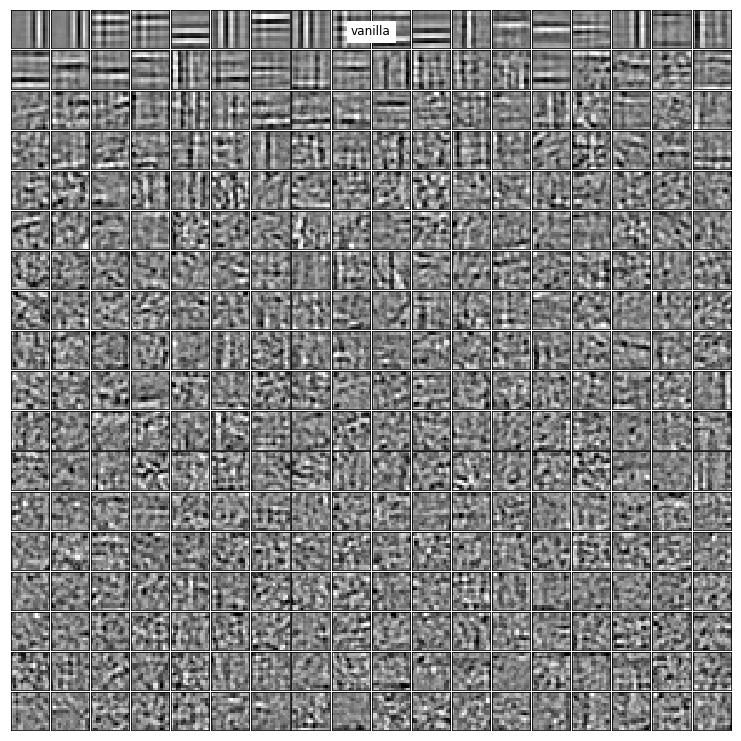

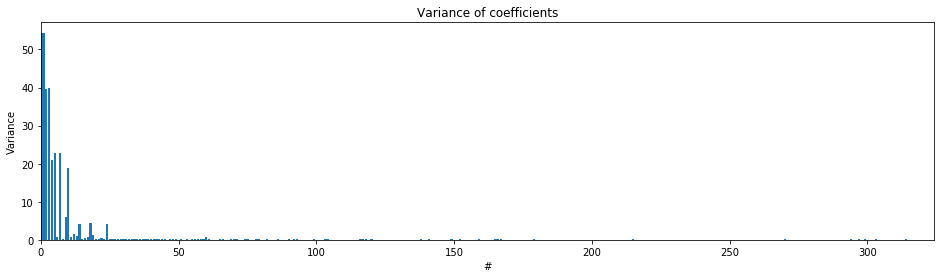

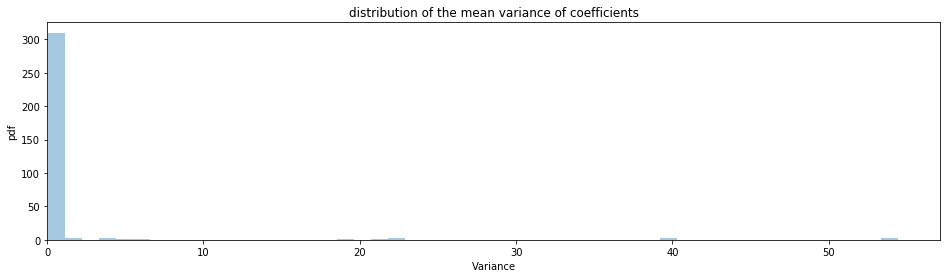

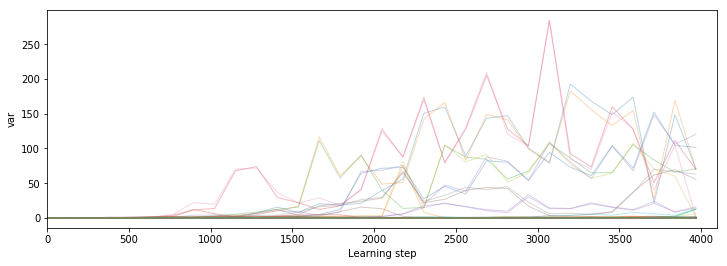

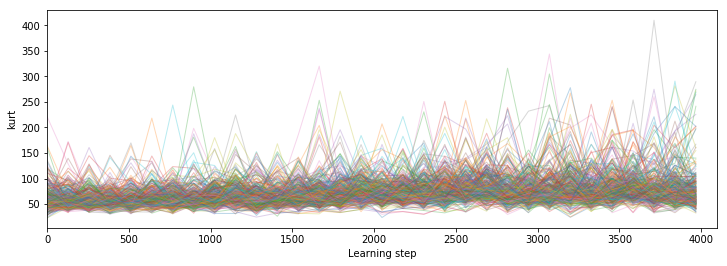

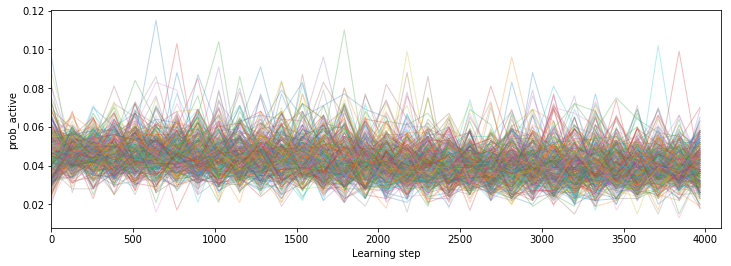

In [8]:
list_figures = ['show_dico', 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']

dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [9]:
help(dico)

Help on SparseHebbianLearning in module shl_scripts.shl_learn object:

class SparseHebbianLearning(builtins.object)
 |  Sparse Hebbian learning
 |  
 |  Finds a dictionary (a set of atoms) that can best be used to represent data
 |  using a sparse code.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_dictionary : int,
 |      Number of dictionary elements to extract
 |  
 |  eta : float
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  n_iter : int,
 |      total number of iterations to perform
 |  
 |  eta_homeo : float
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  alpha_homeo : float
 |      Gives the smoothing exponent  for the homeostatic gain
 |      If equal to 1 the homeostatic learning rule learns a linear relation to
 |      variance.
 |  
 |  dictionary : array of shape (n_dictionary, n_pixels),
 |      initial value of the dictionary for warm restart scenarios
 |      Use ``None`` for a new learning.
 |  
 |  fit_algorithm : {'mp

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (324, 256)
average of filters =  -3.42499711005e-05 +/- 0.00463196218714
average energy of filters =  1.0 +/- 7.80185215239e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [11]:
sparse_code = shl.code(data, dico, matname=matname, l0_sparseness=45)
print('number of codes, size of codewords = ', sparse_code.shape)
print('average of codewords = ', sparse_code.mean())
print('average energy of codewords = ', sparse_code.std(axis=0).mean())
print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

loading the code called : /Users/laurentperrinet/tmp/data_cache/vanilla_coding.npy
number of codes, size of codewords =  (819200, 324)
average of codewords =  0.122225121365
average energy of codewords =  0.794394692099
std of the average of individual patches =  0.27133410416


In [12]:
patches = sparse_code @ dico.dictionary
print('number of codes, size of reconstructed images = ', patches.shape)

number of codes, size of reconstructed images =  (819200, 256)


In [13]:
error = data - patches
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SE = np.sqrt(np.sum(error**2, axis=1))
print('average energy of residual = ', SE.mean(), '+/-', SE.std())

average of residual patches =  0.00162686411136 +/- 0.0700553968386
average energy of residual =  10.3271506918 +/- 9.92813118395


## Version used

In [14]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.3 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]
IPython 6.2.1
OS Darwin 17.0.0 x86_64 i386 64bit
numpy 1.13.3
shl_scripts 2017-02-09
Wed Nov 15 13:35:19 2017 CET